# Warehouse Robot on a Slippery Floor

<a class="anchor" id="Toc"><a>
# Table of Content
1. [Install libraries](#install_libraries)
1. [Import libraries](#import_libraries)
1. [Create and Inspect](#create_and_inspect)
1. [Q-Learning Implementation](#q_learning_implementation)
1. [Training Q-Learning Agent](#q_learning_training)
1. [Evaluation](#evaluation)
1. [Optimization](#optimization)


<a class="anchor" id="install_libraries"></a>
# Install libraries

In [6]:
# install requirements from requirements.txt
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


<a class="anchor" id="import_libraries"></a>
# Import libraries

In [6]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import display, clear_output
import time
import networkx as nx
from gymnasium.envs.toy_text.frozen_lake import MAPS as FROZEN_LAKE_MAPS
import seaborn as sns
from tabulate import tabulate
import itertools
import math

<a class='anchor' id='create_and_inspect'></a>
# Create and Inspect

In [35]:
'''function to initialize the FrozenLake environment with parameters in order to avoid early termination it is added parameter max_episode_steps set to 1000 by default'''
def get_env(env_name: str="FrozenLake-v1", map_name: str="4x4", is_slippery: bool=True, render_mode: str="rgb_array", max_episode_steps: int = 1000):
    env = gym.make(env_name, map_name=map_name, is_slippery=is_slippery, render_mode=render_mode, max_episode_steps=max_episode_steps)
    return env

env = get_env("FrozenLake-v1", "4x4", True, "ansi") # when slippery is True, the agent may not move in the intended direction add randomness to the environment

# basic info
env.reset()
print(env.render())
print("Action space size:", env.action_space.n)
print("Observation space size:", env.observation_space.n)


SFFF
FHFH
FFFH
HFFG

Action space size: 4
Observation space size: 16


Gym environment have built-in reward system were:
- Move to a Frozen tile(F) give 0 reward
- Fall into a Hole(H) give 0 reward and end the episode
- Reaching the Goal(G) give reward 1 and end the episode

([0], [5])

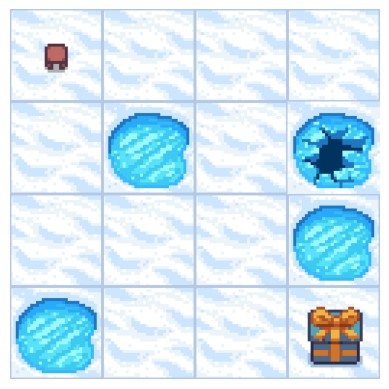

In [23]:
# Test and Visualize a random policy(random_movement) and heuristic policy(heuristic_movement were the agent tries to move right until the edge and down towards the goal)
def run_random_episodes(env: gym.Env, visualize: bool = True, episodes: int = 30):# episodes are the number of tries for the robot to reach the goal
    success_flags = []
    number_of_steps = []
    for episode in range(episodes):
        state, info = env.reset() # reset the environment and get the initial state
        done = False
        steps = 0
        while not done:
            action = env.action_space.sample()  # Take a random action, action is an integer representing the action taken by the agent. In FrozenLake, there are four possible actions: 0 (left), 1 (down), 2 (right), and 3 (up).
            state, reward, done, truncated, info = env.step(action)
            '''state: is an integer representing the agent's current position on the grid. in a 4x4 grid, the states are numbered from 0 to 15, starting from the top-left corner (0) to the bottom-right corner (15).
               reward: is a float value that indicates the immediate reward received after taking the action. In FrozenLake, the reward is typically 0 for most transitions, except when the agent reaches the goal state, where it receives a reward of 1.
               done: is a boolean flag that indicates whether the episode has ended. An episode ends when the agent reaches a terminal state, such as falling into a hole or reaching the goal.
               truncated: is a boolean flag that indicates whether the episode was truncated due to reaching the maximum number of steps allowed in the environment.
               info: is a dictionary that may contain additional information about the environment's state or the action taken.'''
            steps += 1
            if visualize: # visualize the robot's movement to see how it explores the environment
                animation_speed = 0.5  # seconds between frames
                plt.ion()
                img = env.render()
                plt.imshow(img)
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
                time.sleep(animation_speed)
                if done or steps >= 30:
                    clear_output(wait=False)
                    plt.ioff()
                    break
    
        success_flags.append(reward)
        number_of_steps.append(steps)
        
    return success_flags, number_of_steps
        

def run_heuristic_episodes(env: gym.Env, visualize: bool = True, episodes: int = 30):
    success_flags = []
    number_of_steps = []
    for episode in range(episodes):
        steps = 0
        state, info = env.reset()
        done = False
        while not done:
            # Heuristic: Move right if possible, else move down
            row = state // int(np.sqrt(env.observation_space.n))
            col = state % int(np.sqrt(env.observation_space.n))

            if col < np.sqrt(env.observation_space.n) - 1:
                        action = 2  # right
            else:
                        action = 1  # down

            state, reward, done, truncated, info = env.step(int(action))
            steps += 1
            if visualize:
                    animation_speed = 0.5  # seconds between frames
                    plt.ion()
                    img = env.render()
                    plt.imshow(img)
                    plt.axis('off')
                    clear_output(wait=True)
                    display(plt.gcf())
                    time.sleep(animation_speed)
                    if done:
                        clear_output(wait=False)
                        plt.ioff()
                        break
        success_flags.append(reward)
        number_of_steps.append(steps)
    return success_flags, number_of_steps

env = get_env("FrozenLake-v1", "4x4", True, "rgb_array", max_episode_steps=100) # make it rgb_array for visualization
run_random_episodes(env, visualize=True, episodes=1)
time.sleep(2)
run_heuristic_episodes(env, visualize=True, episodes=1)

In [6]:
def action_transitions(env, state, action_name="Right"):
    '''this function shows the possible transitions from a given state when taking a specific action in the FrozenLake environment.'''
    action_map = {"Left": 0, "Down": 1, "Right": 2, "Up": 3}
    a = action_map[action_name]
    env_raw = env.unwrapped

    print(f"\nFrom state {state}, if you try to move {action_name.lower()}:")
    transitions = env_raw.P[state][a]
    for prob, next_state, reward, done in transitions:
        if prob > 0:
            print(f"  - {prob*100:.1f}% chance of moving to state {next_state} "f"(reward={reward}, done={done})") if state != next_state else print(f"  - {prob*100:.1f}% chance of staying in state {state} "f"(reward={reward}, done={done})")   
action_transitions(env, state=0, action_name="Right")
action_transitions(env, state=6, action_name="Down")


From state 0, if you try to move right:
  - 33.3% chance of moving to state 4 (reward=0, done=False)
  - 33.3% chance of moving to state 1 (reward=0, done=False)
  - 33.3% chance of staying in state 0 (reward=0, done=False)

From state 6, if you try to move down:
  - 33.3% chance of moving to state 5 (reward=0, done=True)
  - 33.3% chance of moving to state 10 (reward=0, done=False)
  - 33.3% chance of moving to state 7 (reward=0, done=True)


<a class="anchor" id="q_learning_implementation"></a>
# Q-Learning Implementation

In [9]:
# intialize the Q-table
'''Q- learning table example
State | Left   Down   Right   Up
--------------------------------
0     | 0.12   0.05   0.22    0.00
1     | 0.00   0.03   0.18    0.04
from each state the robot takes an action with the highest Q-value
''' 
n_states = env.observation_space.n
n_actions = env.action_space.n

Q_table = np.zeros((n_states, n_actions))
print("Q table shape:")
print(Q_table.shape)



Q table shape:
(16, 4)


In [10]:
# define ε-greedy action policy
def epsilon_greedy_policy(Q, state, epsilon):
    '''this function implements the ε-greedy policy for action selection in Q-learning.
    it gives the robot chance to explore and learn the environment'''
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore: select a random action
    else:
        return np.argmax(Q[state])  # Exploit: select the action with max value (greedy)

In [11]:
def epsilon_decay_normal(initial_epsilon: float, min_epsilon: float, decay_rate: float): # exponential epsilon decay function
    '''since the robot need to stick to its learned policy over time, this function exponentially reduces the 
    exploration rate (epsilon)'''
    return max(min_epsilon, initial_epsilon * decay_rate)

'''there are also aternative epsilon decay functions we will use for expermenting and will be writen down here'''
# linear way 
def epsilon_linear_decay(t, total_episodes, epsilon_initial, epsilon_min):
    '''Linear decay of epsilon over 80% of training'''
    stop = int(0.8*total_episodes)
    if t > stop:
        return epsilon_min
    return epsilon_initial -(epsilon_initial-epsilon_min)*(t/stop)

# Inverse decay
def epsilon_inverse_decay(episode: int, epsilon_initial: float, epsilon_min: float, k: float=0.001):
    return max(epsilon_min, epsilon_initial / (1+k*episode))

# Cosine decay
def epsilon_cosine_decay(episode: int, total_episodes: float, epsilon_initial: float, epsilon_min: float):
    consine_term = (1 + math.cos(math.pi * episode/total_episodes))/2
    return epsilon_min + (epsilon_initial - epsilon_min)*consine_term

# step decay
def epsilon_step_decay(episode: int, step_size: int, epsilon_initial: float, epsilon_min: float, decay_factor: float=0.5):
    steps = episode // step_size
    epsilon = epsilon_initial*(decay_factor**steps)
    return max(epsilon_min, epsilon)

### Q-Learning Update Rule

The Q-learning update rule is defined as:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

####  Variable Definitions

- \( Q(s, a) \): Estimated value of taking action \( a \) in state \( s \).
- \( \alpha \): Learning rate (how quickly the agent updates its knowledge).
- \( r \): Reward received after taking action \( a \) in state \( s \).
- \( \gamma \): Discount factor (how much future rewards are valued).
- \( \max_{a'} Q(s', a') \): Maximum estimated value of the next state \( s' \), over all possible actions \( a' \).
- \( s \): Current state.
- \( a \): Action taken in state \( s \).
- \( s' \): Next state after taking action \( a \).
- \( a' \): A possible action in the next state \( s' \).

In [12]:
def q_update(Q: np.ndarray, state: int, action: int, reward: float, next_state: int, alpha: float, gamma: float, done: bool):
    '''Q-learning update rule function based on the formula above'''
    target = reward + gamma * np.max(Q[next_state])*(not done)
    Q[state][action] += alpha * (target - Q[state][action])

<a class="anchor" id="q_learning_training"></a>
# Training Robot with Q-learning
Goal

- Run multiple episodes to train the agent:

- Use the ε-greedy policy from before.

- Add ε decay (less exploration over time).

- Update the Q-table after every step.

- Track episode returns and success rate


In [16]:
def q_learning_training(env: gym.Env, num_episodes: int, alpha: float, gamma: float, epsilon: float, epsilon_min: float, epsilon_decay: float, visualize: bool = False, epsilon_scheduling_type: str = 'normal', early_stopping: bool = True):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    epsilon_initial = epsilon
    
    # tracking variables
    rewards = [] # total rewards per episode
    success_flags = [] # 1 if goal reached, else 0
    total_steps = [] # total steps per episode
    stable_counter = 0 # counter for convergence checking

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon) # ε-greedy action selection
            # Take a step in the environment
            steps += 1
            next_state, reward, done, truncated, info = env.step(action)
            # Q-value update
            q_update(Q, state, action, reward, next_state, alpha, gamma, done)
            state = next_state
            total_reward += reward
            done = done or truncated
            # Visualization
            if visualize:
                env.render()
                img = env.render()
                plt.imshow(img) 
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
                if done:
                    clear_output(wait=False)
        # record results
        rewards.append(total_reward)
        success_flags.append(1 if done and reward > 0 else 0)
        total_steps.append(steps)

        # Decay epsilon
        if epsilon_scheduling_type == 'normal':
            epsilon = epsilon_decay_normal(epsilon, epsilon_min, epsilon_decay)
        
        elif epsilon_scheduling_type == 'linear':
            epsilon = epsilon_linear_decay(episode, num_episodes, epsilon_initial, epsilon_min)
        
        elif epsilon_scheduling_type == 'inverse':
            epsilon = epsilon_inverse_decay(episode, epsilon_initial, epsilon_min)
        
        elif epsilon_scheduling_type == 'cosine':
            epsilon = epsilon_cosine_decay(episode, num_episodes, epsilon_initial, epsilon_min)
        
        elif epsilon_scheduling_type == 'step':
            epsilon = epsilon_step_decay(episode, step_size=1000, epsilon_initial=epsilon_initial, epsilon_min=epsilon_min, decay_factor=0.5)
            


        # check for convergence every 100 episodes        '''
        if (episode + 1) % 200 == 0 and early_stopping:
            '''check if success rate is stable over the last 3 windows'''
            recent_success_rate = np.mean(success_flags[-1000:])
            previous_success_rate = np.mean(success_flags[-2000:-1000])
            improvement = abs(recent_success_rate - previous_success_rate)
            if improvement < 0.02 and  recent_success_rate > 0:
                stable_counter += 1
            else:
                stable_counter = 0
            
            if stable_counter >= 5:
                break
        
        

            
    return Q, rewards, success_flags, total_steps, episode + 1




<a class="anchor" id="evaluation"></a>
# Evaluation

c:\Users\welde\miniconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\welde\miniconda3\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


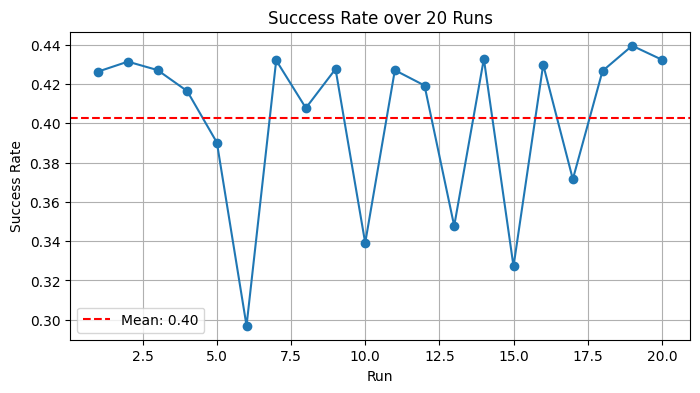

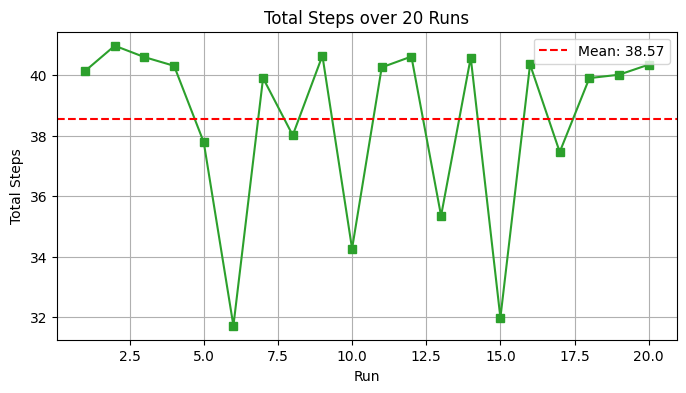

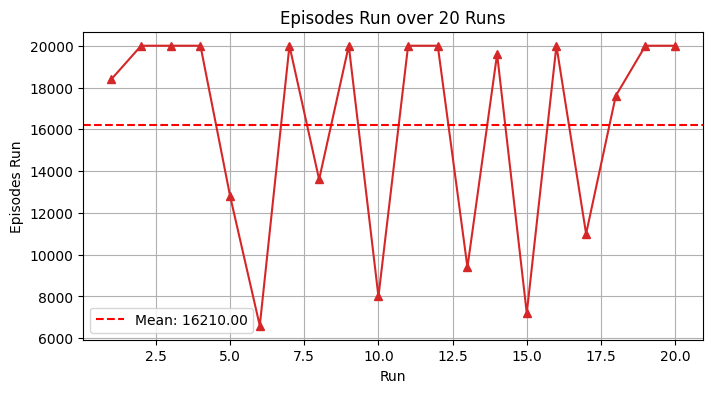

In [17]:
'''in order to make sure that the result is not just lack we are going to train the model 20 times and compare the results'''
success_rates = []
total_steps_list = []
episodes_run_list = []

for i in range(20):
    env = get_env("FrozenLake-v1", "4x4", True, "rgb_array", max_episode_steps=100)
    Q, rewards, success_flags, total_steps, episodes_run = q_learning_training(
        env,
        num_episodes=20000,
        alpha=0.8,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.999,
        visualize=False,
        epsilon_scheduling_type='normal',
        early_stopping=True
    )

    success_rates.append(np.mean(success_flags))
    total_steps_list.append(np.mean(total_steps))
    episodes_run_list.append(episodes_run)

runs = range(1, 21)

# --- Plot 1: Success Rate ---
plt.figure(figsize=(8, 4))
plt.plot(runs, success_rates, marker='o', color='tab:blue')
plt.xlabel('Run')
plt.axhline(y=np.mean(success_rates), color='r', linestyle='--', label=f'Mean: {np.mean(success_rates):.2f}')
plt.ylabel('Success Rate')
plt.title('Success Rate over 20 Runs')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot 2: Total Steps ---
plt.figure(figsize=(8, 4))
plt.plot(runs, total_steps_list, marker='s', color='tab:green')
plt.xlabel('Run')
plt.axhline(y=np.mean(total_steps_list), color='r', linestyle='--', label=f'Mean: {np.mean(total_steps_list):.2f}')
plt.ylabel('Total Steps')
plt.title('Total Steps over 20 Runs')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot 3: Episodes Run ---
plt.figure(figsize=(8, 4))
plt.plot(runs, episodes_run_list, marker='^', color='tab:red')
plt.xlabel('Run')
plt.axhline(y=np.mean(episodes_run_list), color='r', linestyle='--', label=f'Mean: {np.mean(episodes_run_list):.2f}')
plt.ylabel('Episodes Run')
plt.title('Episodes Run over 20 Runs')
plt.grid(True)
plt.legend()
plt.show()


from the results we can see that the results where more or less similiar so the model training is consistent on giving the same results. next we are going to compare the model with random and herusitic policies and it must outpreform them even before optimization.

In [24]:
# run a random policy and heuristic policy for comparison
random_success_flags, random_number_of_steps = run_random_episodes(env, visualize=False, episodes=episodes_run)
heuristic_success_flags, heuristic_number_of_steps = run_heuristic_episodes(env, visualize=False, episodes=episodes_run)

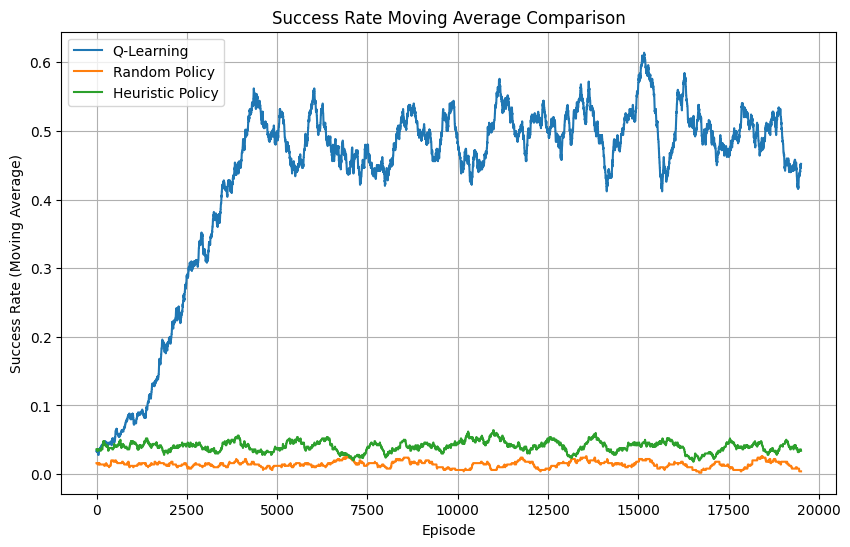

+------------------+----------------+-----------------+
| Policy           |   Success Rate |   Average Steps |
+==================+================+=================+
| Q-Learning       |         0.4324 |           40.35 |
+------------------+----------------+-----------------+
| Random Policy    |         0.014  |            7.72 |
+------------------+----------------+-----------------+
| Heuristic Policy |         0.0401 |            5.76 |
+------------------+----------------+-----------------+


In [25]:
# plot function for comparison with success rate moving average
def success_rate_moving_average(success_flags_list: list[list], title:str, labels: list[str], window_size: int = 100):
    plt.figure(figsize=(10, 6))
    for i, success_flags in enumerate(success_flags_list):
        moving_avg = np.convolve(success_flags, np.ones(window_size)/window_size, mode='valid')
        plt.plot(moving_avg, label=labels[i])

    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Success Rate (Moving Average)')
    plt.legend()
    plt.grid(True)
    plt.show()

# table function for final success rates and number of steps comparison
def table_success_rates(success_flags_list: list[list], total_steps_list: list[list], labels: list[str]):
    success_rates = [np.mean(flags) for flags in success_flags_list]
    average_steps = [np.mean(steps) for steps in total_steps_list]
    table = [[labels[i], f"{success_rates[i]:.4f}", f"{average_steps[i]:.2f}"] for i in range(len(labels))]
    print(tabulate(table, headers=["Policy", "Success Rate", "Average Steps"], tablefmt="grid"))

success_rate_moving_average(
    success_flags_list=[success_flags, random_success_flags, heuristic_success_flags],
    title="Success Rate Moving Average Comparison",
    labels=["Q-Learning", "Random Policy", "Heuristic Policy"],
    window_size=500
)
table_success_rates(
    success_flags_list=[success_flags, random_success_flags, heuristic_success_flags],
    total_steps_list=[total_steps, random_number_of_steps, heuristic_number_of_steps],
    labels=["Q-Learning", "Random Policy", "Heuristic Policy"]
)



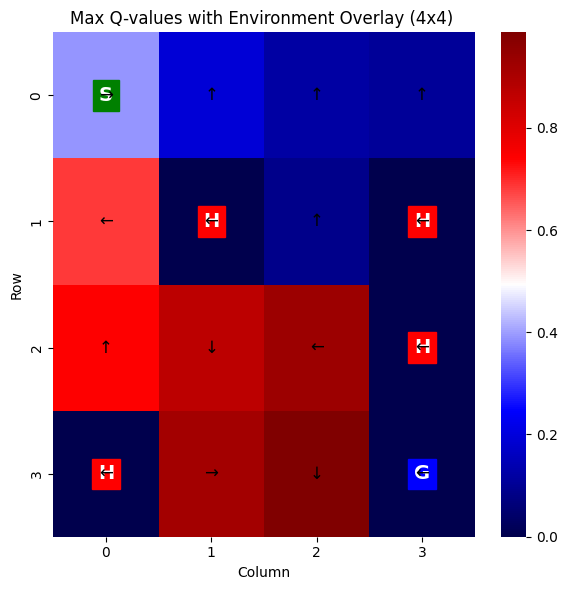

In [18]:
# plot function for q_value heatmap
def plot_q_value_heatmap_with_env(Q: np.ndarray, env_desc: np.ndarray, show_policy: bool = True, cmap: str = "viridis", title_suffix: str = ""):
    """
    Plot a heatmap of max Q-values per state, overlaying holes (H), start (S), and goal (G).

    Parameters
    Q : np.ndarray
        Q-table of shape [n_states, n_actions].
    env_desc : np.ndarray
        The environment description (from env.unwrapped.desc).
    show_policy : bool
        Whether to overlay arrows showing the best action per state.
    cmap : str
        Colormap for heatmap.
    """

    n_states, n_actions = Q.shape
    grid_size = env_desc.shape[0]

    # Max Q-value per state
    max_q_values = np.max(Q, axis=1).reshape(grid_size, grid_size)

    # Create base heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(max_q_values, annot=False, cmap=cmap, cbar=True)
    plt.title(f"Max Q-values with Environment Overlay ({grid_size}x{grid_size}) {title_suffix}")
    plt.xlabel("Column")
    plt.ylabel("Row")

    # Overlay environment tiles (S, H, G)
    for i in range(grid_size):
        for j in range(grid_size):
            tile = env_desc[i, j].decode("utf-8")  
            if tile == 'S':
                plt.text(j + 0.5, i + 0.5, 'S', color='white', ha='center', va='center',
                         fontsize=14, fontweight='bold', backgroundcolor='green')
            elif tile == 'H':
                plt.text(j + 0.5, i + 0.5, 'H', color='white', ha='center', va='center',
                         fontsize=14, fontweight='bold', backgroundcolor='red')
            elif tile == 'G':
                plt.text(j + 0.5, i + 0.5, 'G', color='white', ha='center', va='center',
                         fontsize=14, fontweight='bold', backgroundcolor='blue')

    # Overlay best policy arrows
    if show_policy:
        actions = np.argmax(Q, axis=1).reshape(grid_size, grid_size)
        arrows = ['←', '↓', '→', '↑']  # Gym’s action order
        for i in range(grid_size):
            for j in range(grid_size):
                plt.text(j + 0.5, i + 0.5, arrows[actions[i, j]],
                         color='black', ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()
plot_q_value_heatmap_with_env(Q, env_desc=env.unwrapped.desc, show_policy=True, cmap="seismic")

we can see that the model have learned the most ideal path from the heat map now we will try to run the model on 8x8 map

In [13]:
# intialize the FrozenLake environment with 8x8 map
env_8x8 = get_env("FrozenLake-v1", "8x8", True, "rgb_array", max_episode_steps=500)

In [19]:
# run the model on 8x8 map

Q_8x8, rewards_8x8, success_flags_8x8, total_steps_8x8, episodes_run_8x8 = q_learning_training(
    env_8x8,
    num_episodes=40000,
    alpha=0.8,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.999,
    visualize=False,
)
success_rate_8x8 = np.mean(success_flags_8x8)
print(f"8x8 Map Success Rate: {success_rate_8x8:.4f}")

c:\Users\welde\miniconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\welde\miniconda3\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8x8 Map Success Rate: 0.0000


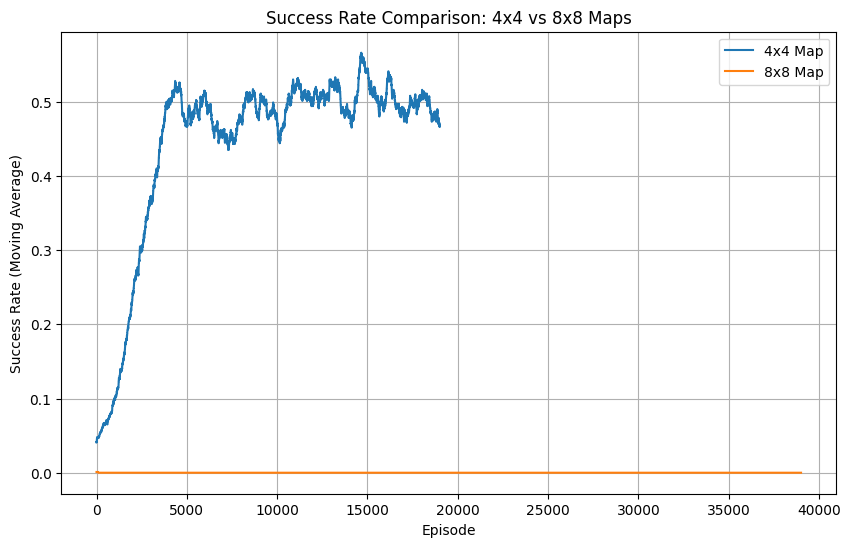

In [26]:
# compare success rates on 4x4 and 8x8 maps
success_rate_moving_average(
    success_flags_list=[success_flags, success_flags_8x8], title="Success Rate Comparison: 4x4 vs 8x8 Maps", labels=["4x4 Map", "8x8 Map"], window_size=1000
)

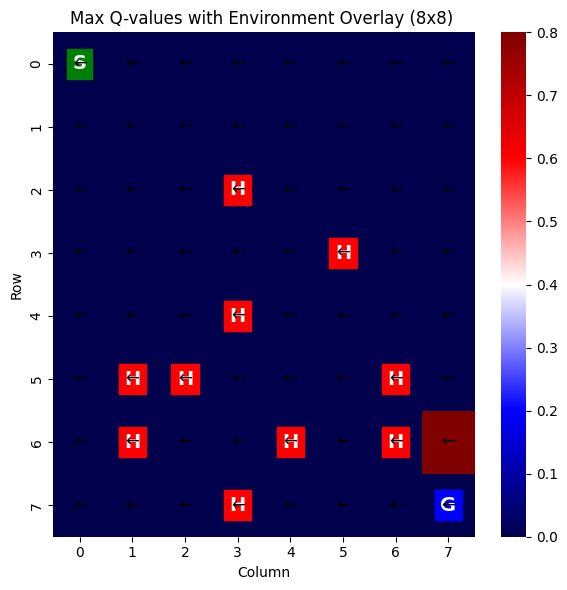

In [27]:
# 8x8 heatmap
plot_q_value_heatmap_with_env(Q_8x8, env_desc=env_8x8.unwrapped.desc, show_policy=True, cmap="seismic")

on the larger map since the robot have not reached the goal even once the Q-table have not learned anything that sounds like an issue to be resolved in the next chapter which is optimization.

<a class="anchor" id="optimization"></a>
# Optimization

I want to start optimization by studing the different epsilon decay methods and how the epsilon evolve on 10,000, 50,000 and 100,000 on each of them

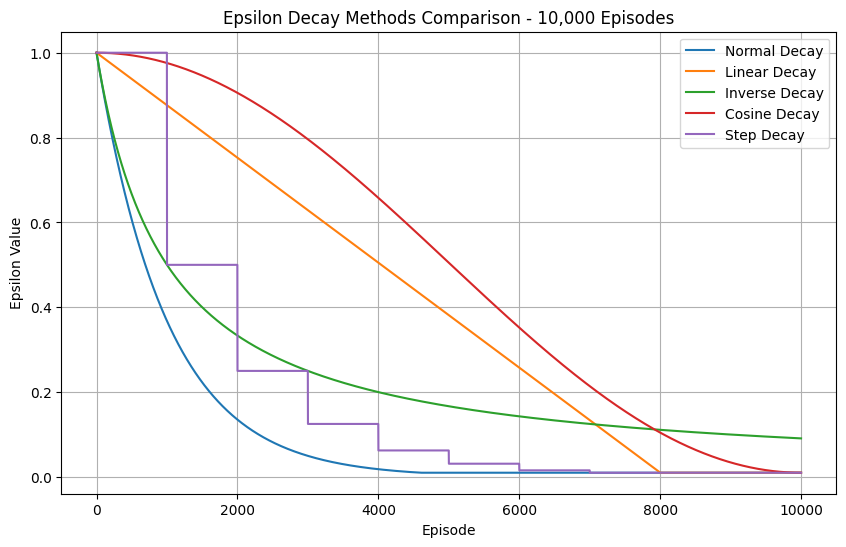

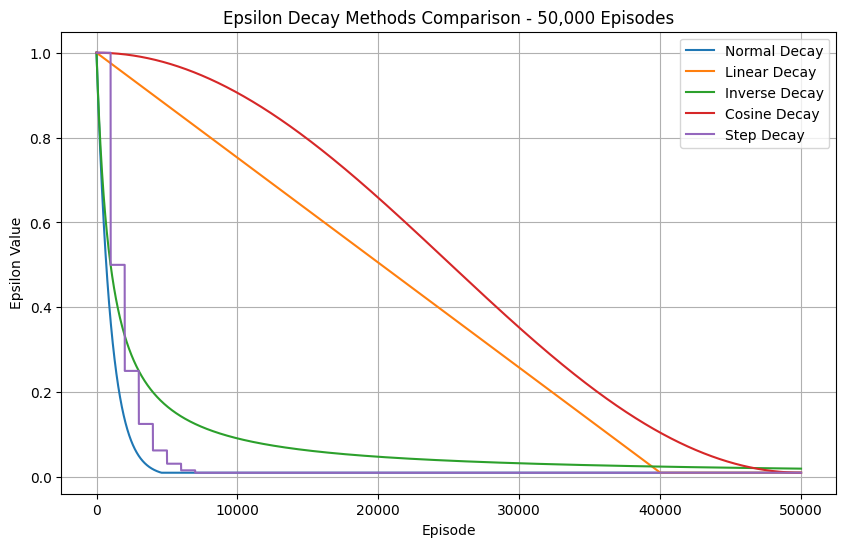

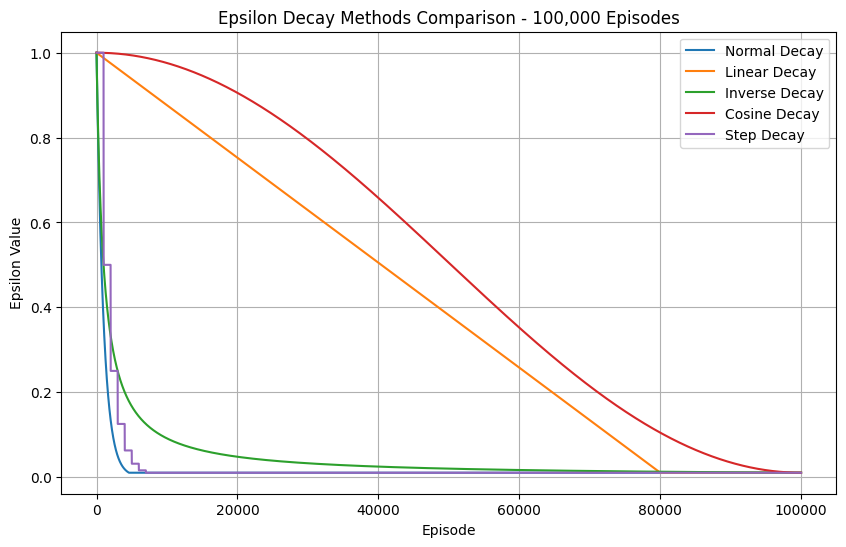

In [28]:
# compare epsilon decay methods by plotting epsilon over episodes
def plot_epsilon_decay(methods: list[str], num_episodes: int = 100000, epsilon_initial: float = 1.0, epsilon_min: float = 0.01, title: str = "Epsilon Decay Methods Comparison"):
    plt.figure(figsize=(10, 6))
    episodes = np.arange(num_episodes)
    
    for method in methods:
        epsilons = []
        for episode in episodes:
            if method == 'normal':
                epsilon = epsilon_decay_normal(epsilon_initial, epsilon_min, decay_rate=0.999**episode)
            elif method == 'linear':
                epsilon = epsilon_linear_decay(episode, num_episodes, epsilon_initial, epsilon_min)
            elif method == 'inverse':
                epsilon = epsilon_inverse_decay(episode, epsilon_initial, epsilon_min)
            elif method == 'cosine':
                epsilon = epsilon_cosine_decay(episode, num_episodes, epsilon_initial, epsilon_min)
            elif method == 'step':
                epsilon = epsilon_step_decay(episode, step_size=1000, epsilon_initial=epsilon_initial, epsilon_min=epsilon_min, decay_factor=0.5)
            epsilons.append(epsilon)
        
        plt.plot(episodes, epsilons, label=method.capitalize() + " Decay")
    
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_epsilon_decay(methods=['normal', 'linear', 'inverse', 'cosine', 'step'], num_episodes=10000, title="Epsilon Decay Methods Comparison - 10,000 Episodes")
plot_epsilon_decay(methods=['normal', 'linear', 'inverse', 'cosine', 'step'], num_episodes=50000, title="Epsilon Decay Methods Comparison - 50,000 Episodes")
plot_epsilon_decay(methods=['normal', 'linear', 'inverse', 'cosine', 'step'], num_episodes=100000, title="Epsilon Decay Methods Comparison - 100,000 Episodes")

In [99]:
# try each decap on 4x4 map
decay_methods = ['normal','linear', 'inverse', 'cosine', 'step']
results = {}
for method in decay_methods:
    Q, rewards, success_flags, total_steps, episodes_run = q_learning_training(
        env,
        num_episodes=50000,
        alpha=0.8,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.999,
        visualize=False,
        epsilon_scheduling_type=method,
        early_stopping=False
    )
    success_rate = np.mean(success_flags)
    results[method] = {
        "Q": Q,
        "rewards": rewards,
        "success_flags": success_flags,
        "total_steps": total_steps,
        "episodes_run": episodes_run,
        "success_rate": success_rate
    }
    print(f"{method.capitalize()} Decay Success Rate: {success_rate:.4f}")

Normal Decay Success Rate: 0.4628
Linear Decay Success Rate: 0.1531
Inverse Decay Success Rate: 0.2904
Cosine Decay Success Rate: 0.1023
Step Decay Success Rate: 0.4499


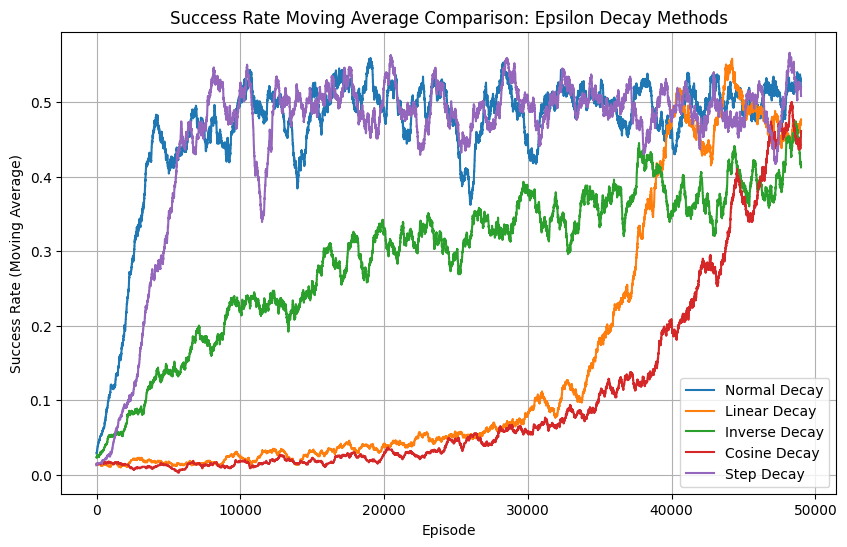

+---------------+----------------+-----------------+
| Policy        |   Success Rate |   Average Steps |
+===============+================+=================+
| Normal Decay  |         0.4628 |           43.61 |
+---------------+----------------+-----------------+
| Linear Decay  |         0.1531 |           19.65 |
+---------------+----------------+-----------------+
| Inverse Decay |         0.2904 |           31.45 |
+---------------+----------------+-----------------+
| Cosine Decay  |         0.1023 |           15.73 |
+---------------+----------------+-----------------+
| Step Decay    |         0.4499 |           42.02 |
+---------------+----------------+-----------------+


In [137]:
# compare success rate moving averages for different decay methods
success_flags_list = [results[method]["success_flags"] for method in results]
success_rate_moving_average(
    success_flags_list=success_flags_list,
    title="Success Rate Moving Average Comparison: Epsilon Decay Methods",
    labels=[method.capitalize() + " Decay" for method in results],
    window_size=1000
)
# compare success rates in a table
table_success_rates(
    success_flags_list=success_flags_list,
    total_steps_list=[results[method]["total_steps"] for method in results],
    labels=[method.capitalize() + " Decay" for method in results]
)

In [96]:
# do the same for 8x8 map
results_8x8 = {}
for method in decay_methods:
    Q_8x8, rewards_8x8, success_flags_8x8, total_steps_8x8, episodes_run_8x8 = q_learning_training(
        env_8x8,
        num_episodes=100000,
        alpha=0.8,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.999,
        visualize=False,
        epsilon_scheduling_type=method,
        early_stopping=False
    )
    success_rate_8x8 = np.mean(success_flags_8x8)
    results_8x8[method] = {
        "Q": Q_8x8,
        "rewards": rewards_8x8,
        "success_flags": success_flags_8x8,
        "total_steps": total_steps_8x8,
        "episodes_run": episodes_run_8x8,
        "success_rate": success_rate_8x8
    }
    print(f"8x8 Map - {method.capitalize()} Decay Success Rate: {success_rate_8x8:.4f}")

8x8 Map - Normal Decay Success Rate: 0.0000
8x8 Map - Linear Decay Success Rate: 0.1941
8x8 Map - Inverse Decay Success Rate: 0.0000
8x8 Map - Cosine Decay Success Rate: 0.1135
8x8 Map - Step Decay Success Rate: 0.6963


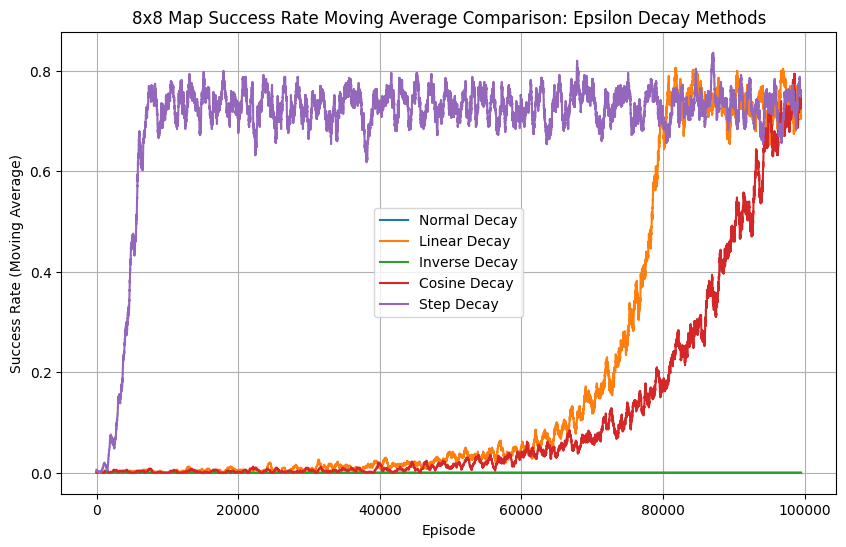

+---------------+----------------+-----------------+
| Policy        |   Success Rate |   Average Steps |
+===============+================+=================+
| Normal Decay  |         0      |          395.13 |
+---------------+----------------+-----------------+
| Linear Decay  |         0.1941 |           69.72 |
+---------------+----------------+-----------------+
| Inverse Decay |         0      |          306.31 |
+---------------+----------------+-----------------+
| Cosine Decay  |         0.1135 |           59.08 |
+---------------+----------------+-----------------+
| Step Decay    |         0.6963 |          139.78 |
+---------------+----------------+-----------------+


In [138]:
# compare success rates on 8x8 map
success_flags_list_8x8 = [results_8x8[method]["success_flags"] for method in results_8x8]
success_rate_moving_average(
    success_flags_list=success_flags_list_8x8,
    title="8x8 Map Success Rate Moving Average Comparison: Epsilon Decay Methods",
    labels=[method.capitalize() + " Decay" for method in results_8x8],
    window_size=500
)
table_success_rates(
    success_flags_list=success_flags_list_8x8,
    total_steps_list=[results_8x8[method]["total_steps"] for method in results_8x8],
    labels=[method.capitalize() + " Decay" for method in results_8x8]
)

Step Decay performs consistently well on both maps, and its advantage becomes especially clear on the 8×8 environment. Although the epsilon decay curves for Step Decay and Normal Decay appear similar, the short intervals where Step Decay holds epsilon constant proved crucial on the larger, more complex map. These steady exploration phases allowed the robot to gather enough experience before reducing exploration, leading to more stable and higher success rates. The best thing about it was that it learned relatively quickly on both maps so the number of episodes could be reduced on future runs giving us less run time.

4x4 Map Normal Decay Success Rate: 0.4841
4x4 Map Step Decay Success Rate: 0.4411
8x8 Map Step Decay Success Rate: 0.5585


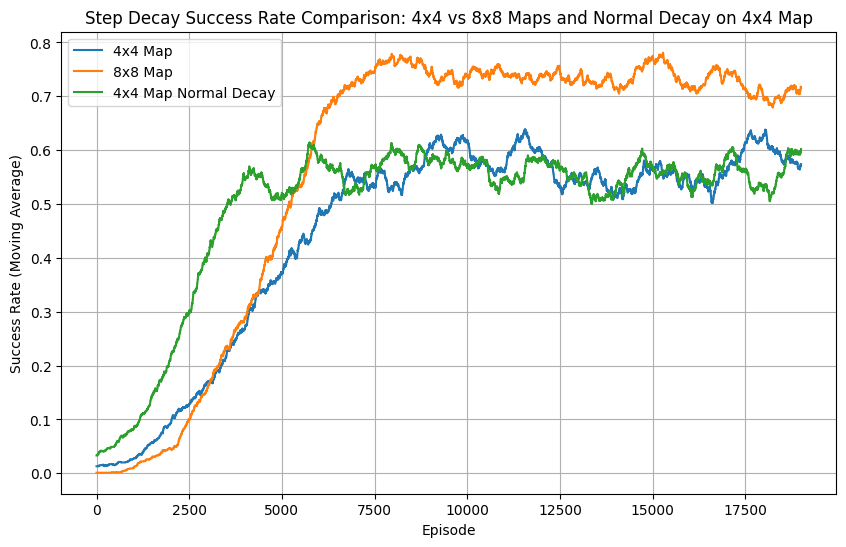

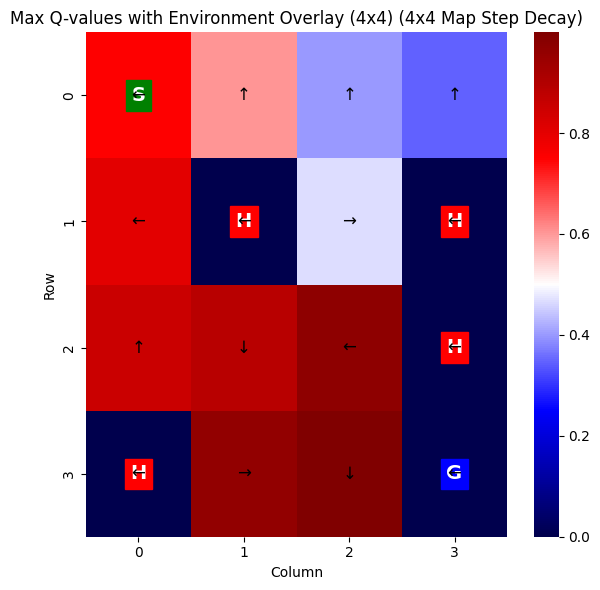

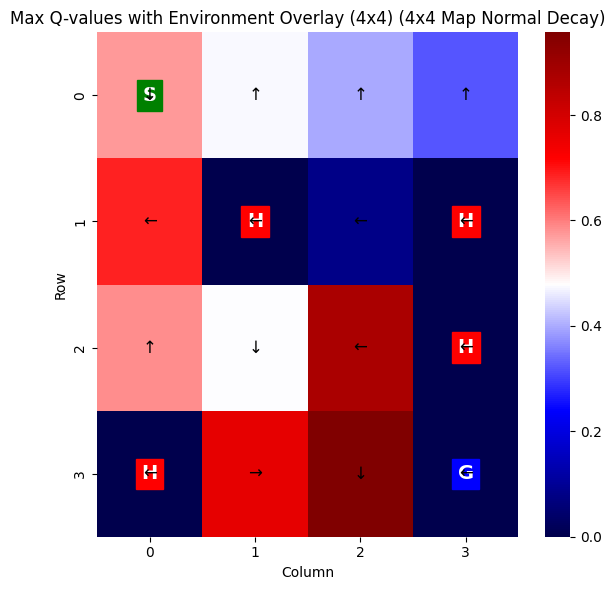

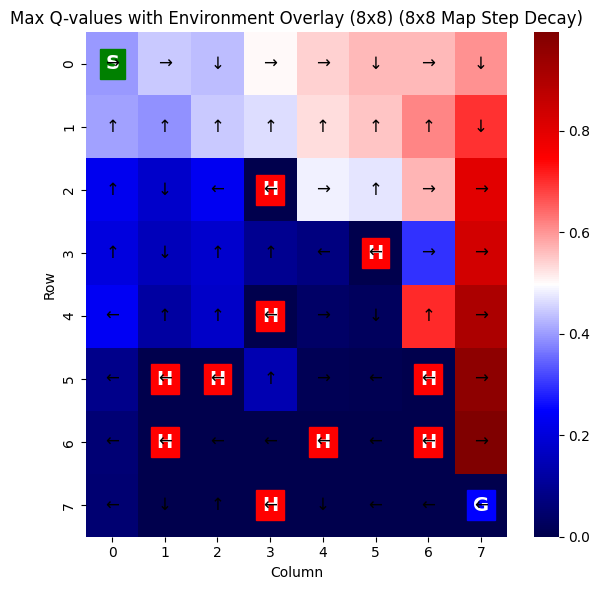

In [38]:
# step decay detailed visualization on both maps and we will add normal decay for 4x4 because it was the best performing one

Q, rewards, success_flags, total_steps, episodes_run = q_learning_training(
    env,
    num_episodes=20000,
    alpha=0.8,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.999,
    visualize=False,
    epsilon_scheduling_type='normal',
    early_stopping=False
)
success_rate = np.mean(success_flags)
print(f"4x4 Map Normal Decay Success Rate: {success_rate:.4f}")

Q_step, rewards_step, success_flags_step, total_steps_step, episodes_run_step = q_learning_training(
    env,
    num_episodes=20000,
    alpha=0.8,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.999,
    visualize=False,
    epsilon_scheduling_type='step',
    early_stopping=False
)
success_rate = np.mean(success_flags_step)
print(f"4x4 Map Step Decay Success Rate: {success_rate:.4f}")

Q_8x8_step, rewards_8x8_step, success_flags_8x8_step, total_steps_8x8_step, episodes_run_8x8_step = q_learning_training(
    env_8x8,
    num_episodes=20000,
    alpha=0.8,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.999,
    visualize=False,
    epsilon_scheduling_type='step',
    early_stopping=False
)
success_rate_8x8 = np.mean(success_flags_8x8_step)
print(f"8x8 Map Step Decay Success Rate: {success_rate_8x8:.4f}")

sucess_flag_list = [success_flags_step, success_flags_8x8_step, success_flags]
success_rate_moving_average(sucess_flag_list, title="Step Decay Success Rate Comparison: 4x4 vs 8x8 Maps and Normal Decay on 4x4 Map", labels=["4x4 Map", "8x8 Map","4x4 Map Normal Decay"], window_size=1000)

plot_q_value_heatmap_with_env(
    Q_step,
    env_desc=env.unwrapped.desc,
    show_policy=True,
    cmap="seismic",
    title_suffix="(4x4 Map Step Decay)"
)
plot_q_value_heatmap_with_env(
    Q,
    env_desc=env.unwrapped.desc,
    show_policy=True,
    cmap="seismic",
    title_suffix="(4x4 Map Normal Decay)"
)
plot_q_value_heatmap_with_env(
    Q_8x8_step,
    env_desc=env_8x8.unwrapped.desc,
    show_policy=True,
    cmap="seismic",
    title_suffix="(8x8 Map Step Decay)"
)

In [40]:
# to find the true success rate we will skip the first 7000 episodes and calculate the success rate on the rest becaause the robot begin to converge around that point
true_success_flags_4x4 = success_flags_step[7000:]
true_success_flags_8x8 = success_flags_8x8_step[7000:]
true_success_flags_normal_4x4 = success_flags[7000:]

# final success table
table_success_rates(
    success_flags_list=[true_success_flags_4x4, true_success_flags_8x8, true_success_flags_normal_4x4],
    total_steps_list=[total_steps_step[7000:], total_steps_8x8_step[7000:], total_steps[7000:]],
    labels=["4x4 Map (Post-Convergence)", "8x8 Map (Post-Convergence)", "4x4 Map Normal Decay (Post-Convergence)"]
)

+-----------------------------------------+----------------+-----------------+
| Policy                                  |   Success Rate |   Average Steps |
+=========================================+================+=================+
| 4x4 Map (Post-Convergence)              |         0.5685 |           52.66 |
+-----------------------------------------+----------------+-----------------+
| 8x8 Map (Post-Convergence)              |         0.7352 |          147.71 |
+-----------------------------------------+----------------+-----------------+
| 4x4 Map Normal Decay (Post-Convergence) |         0.5615 |           53.05 |
+-----------------------------------------+----------------+-----------------+


Eventhough the normal decay is better on 4x4 the difference is very small therefore we are taking forward the step decay as a decay policy going through the optimaization process. But i have to point out the heat map definetely looked better on normal decay maybe we will look back at this method later if there is no improvement from the step decay.

Now we will try to change the reward mechanism making the model get -0.01 on normal steps , -1 if it falls in a hole and +1 if it reaches the goal.

In [29]:
# shaping the reward by giving small negative reward for each step to encourage the agent to reach the goal faster and increase the reward for reaching the goal and penalize falling into holes
def q_learning_training_with_reward_shaping(env: gym.Env, num_episodes: int, alpha: float, gamma: float, epsilon: float, epsilon_min: float, epsilon_decay_stepsize:int = 1000, step_penalty: float = -0.01, goal_reward_bonus: float = 10.0, hole_penalty: float = -10.0, visualize: bool = False):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    epsilon_initial = epsilon
    
    # tracking variables
    rewards = [] # total rewards per episode
    success_flags = [] # 1 if goal reached, else 0
    total_steps = [] # total steps per episode

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon) # ε-greedy action selection
            # Take a step in the environment
            steps += 1
            next_state, real_reward, done, truncated, info = env.step(action)
            reward = real_reward
            # Reward shaping
            if not done:
                reward += step_penalty
            if done and real_reward > 0:
                reward = goal_reward_bonus
            elif done and real_reward == 0:
                reward = hole_penalty
    # -----------------------
            # Q-value update
            q_update(Q, state, action, reward, next_state, alpha, gamma, done)
            state = next_state
            total_reward += reward
            done = done or truncated
            # Visualization
            if visualize:
                env.render()
                img = env.render()
                plt.imshow(img) 
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
                if done:
                    clear_output(wait=False)
        # record results
        rewards.append(total_reward)
        success_flags.append(1 if done and real_reward > 0 else 0)
        total_steps.append(steps)

        # Decay epsilon
        epsilon = epsilon_step_decay(episode, step_size=epsilon_decay_stepsize, epsilon_initial=epsilon_initial, epsilon_min=epsilon_min, decay_factor=0.5)

        
    return Q, rewards, success_flags, total_steps, episode + 1


4x4 Map Step Decay with Reward Shaping Success Rate: 0.3777


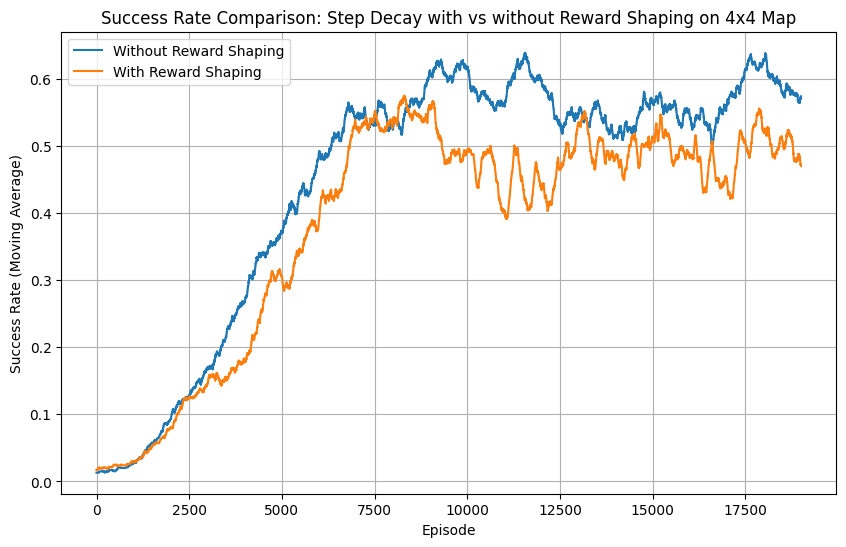

+-------------------------------------------+----------------+-----------------+
| Policy                                    |   Success Rate |   Average Steps |
+===========================================+================+=================+
| Without Reward Shaping (Post-Convergence) |         0.5685 |           52.66 |
+-------------------------------------------+----------------+-----------------+
| With Reward Shaping (Post-Convergence)    |         0.4929 |          127.61 |
+-------------------------------------------+----------------+-----------------+


In [41]:
# train with reward shaping on 4x4 map and compare the results
Q_shaped, rewards_shaped, success_flags_shaped, total_steps_shaped, episodes_run_shaped = q_learning_training_with_reward_shaping(
    env,
    num_episodes=20000,
    alpha=0.8,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay_stepsize=1000,
    step_penalty=-0.01,
    visualize=False
)
success_rate_shaped = np.mean(success_flags_shaped)
print(f"4x4 Map Step Decay with Reward Shaping Success Rate: {success_rate_shaped:.4f}")

success_rate_moving_average(
    success_flags_list=[success_flags_step, success_flags_shaped],
    title="Success Rate Comparison: Step Decay with vs without Reward Shaping on 4x4 Map",
    labels=["Without Reward Shaping", "With Reward Shaping"],
    window_size=1000
)
true_success_flag_list = [success_flags_step[7000:], success_flags_shaped[7000:]]
table_success_rates(
    success_flags_list=true_success_flag_list,
    total_steps_list=[total_steps_step[7000:], total_steps_shaped[7000:]],
    labels=["Without Reward Shaping (Post-Convergence)", "With Reward Shaping (Post-Convergence)"]
)

it looks promising now we will loop with different values to see if there is a change

Step Penalty: -0.01, Goal Reward: 10.0, Hole Penalty: -10.0 => Success Rate: 0.1906
Step Penalty: 0.01, Goal Reward: 10.0, Hole Penalty: -10.0 => Success Rate: 0.1396
Step Penalty: -0.01, Goal Reward: 100, Hole Penalty: -100.0 => Success Rate: 0.1874
Step Penalty: 0.01, Goal Reward: 10.0, Hole Penalty: -100.0 => Success Rate: 0.0401
Step Penalty: -0.01, Goal Reward: 100, Hole Penalty: -10.0 => Success Rate: 0.3748
Step Penalty: -0.01, Goal Reward: 10.0, Hole Penalty: -100.0 => Success Rate: 0.0395
Step Penalty: 0, Goal Reward: 1, Hole Penalty: 0 => Success Rate: 0.3800


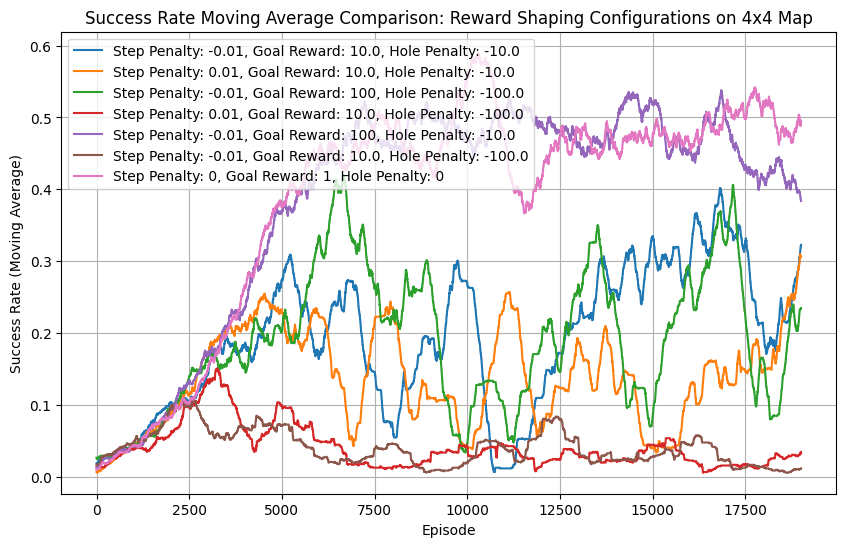

+---------------------------------------------------------------------------------+----------------+-----------------+
| Policy                                                                          |   Success Rate |   Average Steps |
+=================================================================================+================+=================+
| Step Penalty: -0.01, Goal Reward: 10.0, Hole Penalty: -10.0 (Post-Convergence)  |         0.2215 |           72.6  |
+---------------------------------------------------------------------------------+----------------+-----------------+
| Step Penalty: 0.01, Goal Reward: 10.0, Hole Penalty: -10.0 (Post-Convergence)   |         0.1398 |           79.87 |
+---------------------------------------------------------------------------------+----------------+-----------------+
| Step Penalty: -0.01, Goal Reward: 100, Hole Penalty: -100.0 (Post-Convergence)  |         0.2098 |           73.66 |
+-----------------------------------------------

In [158]:
# test with different step penalties, goal rewards, and hole penalties
penalty_configs = [
    {"step_penalty": -0.01, "goal_reward_bonus": 10.0, "hole_penalty": -10.0},
    {"step_penalty": 0.01, "goal_reward_bonus": 10.0, "hole_penalty": -10.0},
    {"step_penalty": -0.01, "goal_reward_bonus": 100, "hole_penalty": -100.0},
    {"step_penalty": 0.01, "goal_reward_bonus": 10.0, "hole_penalty": -100.0},
    {"step_penalty": -0.01, "goal_reward_bonus": 100, "hole_penalty": -10.0},
    {"step_penalty": -0.01, "goal_reward_bonus": 10.0, "hole_penalty": -100.0},
    {"step_penalty": 0, "goal_reward_bonus": 1, "hole_penalty": 0}
]
shaped_results = {}
for config in penalty_configs:
    Q_shaped, rewards_shaped, success_flags_shaped, total_steps_shaped, episodes_run_shaped = q_learning_training_with_reward_shaping(
        env,
        num_episodes=20000,
        alpha=0.8,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay_stepsize=1000,
        step_penalty=config["step_penalty"],
        goal_reward_bonus=config["goal_reward_bonus"],
        hole_penalty=config["hole_penalty"],
        visualize=False
    )
    success_rate_shaped = np.mean(success_flags_shaped)
    key = f"Step Penalty: {config['step_penalty']}, Goal Reward: {config['goal_reward_bonus']}, Hole Penalty: {config['hole_penalty']}"
    shaped_results[key] = {
        "Q": Q_shaped,
        "rewards": rewards_shaped,
        "success_flags": success_flags_shaped,
        "total_steps": total_steps_shaped,
        "episodes_run": episodes_run_shaped,
        "success_rate": success_rate_shaped
    }
    print(f"{key} => Success Rate: {success_rate_shaped:.4f}")
# compare success rates and total steps for different reward shaping configurations
success_flags_list_shaped = [shaped_results[key]["success_flags"] for key in shaped_results]
success_rate_moving_average(
    success_flags_list=success_flags_list_shaped,
    title="Success Rate Moving Average Comparison: Reward Shaping Configurations on 4x4 Map",
    labels=[key for key in shaped_results],
    window_size=1000
)

real_success_flags_shaped = [shaped_results[key]["success_flags"][7000:] for key in shaped_results]
table_success_rates(
    success_flags_list=real_success_flags_shaped,
    total_steps_list=[shaped_results[key]["total_steps"][7000:] for key in shaped_results],
    labels=[key + " (Post-Convergence)" for key in shaped_results]
)




looks like the orginal mechanism is still the best on both success rate and average steps now we do the same with 8x8 map

8x8 Map - Step Penalty: -0.01, Goal Reward: 10.0, Hole Penalty: -10.0 => Success Rate: 0.6180
8x8 Map - Step Penalty: 0.01, Goal Reward: 10.0, Hole Penalty: -10.0 => Success Rate: 0.6324
8x8 Map - Step Penalty: -0.01, Goal Reward: 100, Hole Penalty: -100.0 => Success Rate: 0.6234
8x8 Map - Step Penalty: 0.01, Goal Reward: 10.0, Hole Penalty: -100.0 => Success Rate: 0.6829
8x8 Map - Step Penalty: -0.01, Goal Reward: 100, Hole Penalty: -10.0 => Success Rate: 0.5683
8x8 Map - Step Penalty: -0.01, Goal Reward: 10.0, Hole Penalty: -100.0 => Success Rate: 0.6771
8x8 Map - Step Penalty: 0, Goal Reward: 1, Hole Penalty: 0 => Success Rate: 0.5574


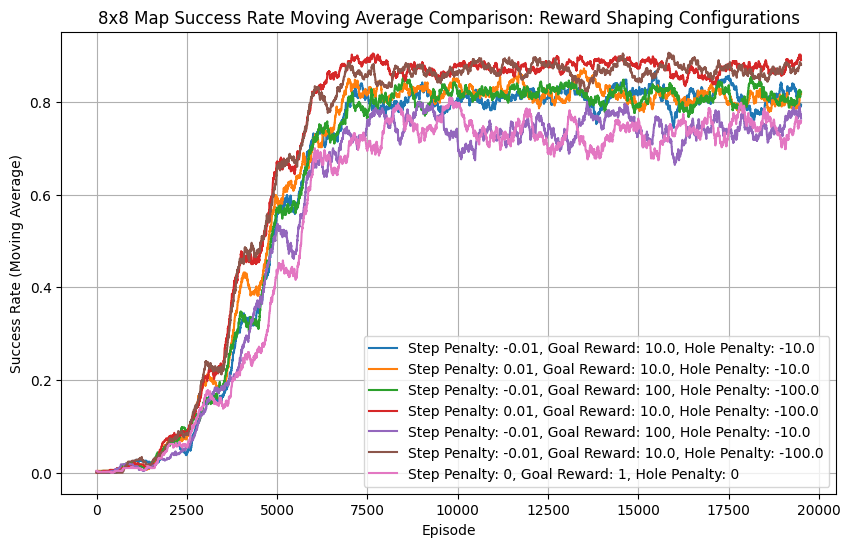

+---------------------------------------------------------------------------------+----------------+-----------------+
| Policy                                                                          |   Success Rate |   Average Steps |
+=================================================================================+================+=================+
| Step Penalty: -0.01, Goal Reward: 10.0, Hole Penalty: -10.0 (Post-Convergence)  |         0.8082 |          156.04 |
+---------------------------------------------------------------------------------+----------------+-----------------+
| Step Penalty: 0.01, Goal Reward: 10.0, Hole Penalty: -10.0 (Post-Convergence)   |         0.8182 |          158.96 |
+---------------------------------------------------------------------------------+----------------+-----------------+
| Step Penalty: -0.01, Goal Reward: 100, Hole Penalty: -100.0 (Post-Convergence)  |         0.8136 |          154.36 |
+-----------------------------------------------

In [159]:
# same with 8x8 map
shaped_results_8x8 = {}
for config in penalty_configs:
    Q_shaped_8x8, rewards_shaped_8x8, success_flags_shaped_8x8, total_steps_shaped_8x8, episodes_run_shaped_8x8 = q_learning_training_with_reward_shaping(
        env_8x8,
        num_episodes=20000,
        alpha=0.8,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay_stepsize=1000,
        step_penalty=config["step_penalty"],
        goal_reward_bonus=config["goal_reward_bonus"],
        hole_penalty=config["hole_penalty"],
        visualize=False
    )
    success_rate_shaped_8x8 = np.mean(success_flags_shaped_8x8)
    key = f"Step Penalty: {config['step_penalty']}, Goal Reward: {config['goal_reward_bonus']}, Hole Penalty: {config['hole_penalty']}"
    shaped_results_8x8[key] = {
        "Q": Q_shaped_8x8,
        "rewards": rewards_shaped_8x8,
        "success_flags": success_flags_shaped_8x8,
        "total_steps": total_steps_shaped_8x8,
        "episodes_run": episodes_run_shaped_8x8,
        "success_rate": success_rate_shaped_8x8
    }
    print(f"8x8 Map - {key} => Success Rate: {success_rate_shaped_8x8:.4f}")

# compare success rates and total steps for different reward shaping configurations on 8x8 map
success_flags_list_shaped_8x8 = [shaped_results_8x8[key]["success_flags"] for key in shaped_results_8x8]
success_rate_moving_average(
    success_flags_list=success_flags_list_shaped_8x8,
    title="8x8 Map Success Rate Moving Average Comparison: Reward Shaping Configurations",
    labels=[key for key in shaped_results_8x8],
    window_size=500
)

real_success_flags_shaped_8x8 = [shaped_results_8x8[key]["success_flags"][7000:] for key in shaped_results_8x8]

table_success_rates(
    success_flags_list=real_success_flags_shaped_8x8,
    total_steps_list=[shaped_results_8x8[key]["total_steps"][7000:] for key in shaped_results_8x8],
    labels=[key + " (Post-Convergence)" for key in shaped_results_8x8]
)

on the other hand in 8x8 map changing the reward mechanism proved to be useful pushing the success rate up to 88% that is why will will move forward with reward shaping mechanism on this map.

Next, we will explore the effects of the learning rate (α) and the discount factor (γ) to determine their optimal values.

- α (alpha) controls how quickly the agent updates its knowledge based on new experiences. A higher α makes learning faster but can  cause instability if updates fluctuate too much, while a lower α results in slower, more stable learning.

- γ (gamma) represents how much the agent values future rewards compared to immediate ones. A high γ makes the agent more farsighted, encouraging it to choose actions that may lead to long-term success. A low γ makes the agent shortsighted, focusing mainly on immediate rewards.

In [54]:
# hyperparameter tuning for alpha and gamma with reward shaping
env_4x4 = get_env("FrozenLake-v1", "4x4", True, "rgb_array", max_episode_steps=100)
def alpha_and_gamma_testing(alpha_values: list, gamma_values: list, num_episodes: int = 20000, map: str = '4x4'):

    results = {}
    if map == '4x4':
        env = env_4x4
        step_penalty = 0
        goal_reward_bonus = 1
        hole_penalty = 0
    else:
        env = env_8x8
        step_penalty = 0.01
        goal_reward_bonus = 10.0
        hole_penalty = -100.0
    for alpha in alpha_values:
        for gamma in gamma_values:
                Q, rewards, success_flags, total_steps, episodes_run =  q_learning_training_with_reward_shaping(
                    env,
                    num_episodes=20000,
                    alpha=alpha,
                    gamma=gamma,
                    epsilon=1.0,
                    epsilon_min=0.01,
                    epsilon_decay_stepsize=1000,
                    step_penalty=step_penalty,
                    goal_reward_bonus=goal_reward_bonus,
                    hole_penalty=hole_penalty,
                visualize=False )
                results[(alpha, gamma)] = {
                'Q': Q,
                'rewards': rewards,
                'success_flags': success_flags,
                'total_steps': total_steps,
                'episodes_run': episodes_run
            }
    return results


In [55]:

alpha_values = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
gamma_values = [0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 0.999]
tuning_results = alpha_and_gamma_testing(alpha_values, gamma_values, map='4x4')

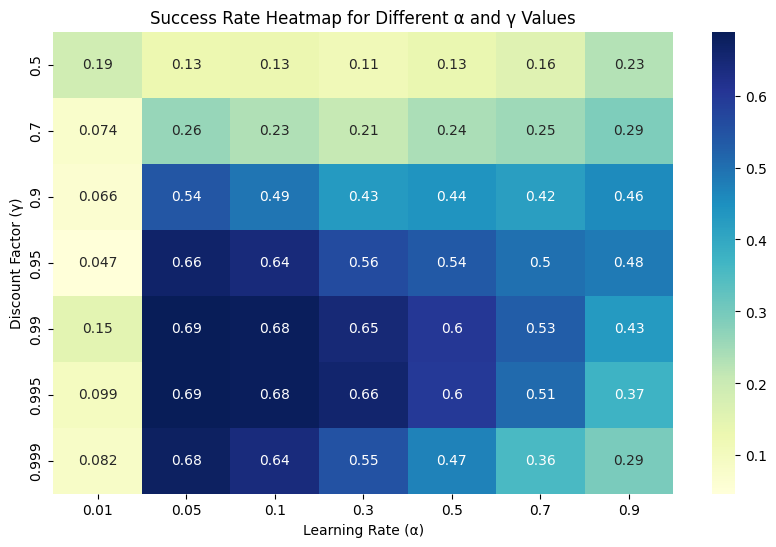

In [56]:
# visualize results in sucess rate using heatmap having alpha and gamma on x and y axis respectively



def success_rate_heatmap(tuning_results: dict, alpha_values: list, gamma_values: list):
    success_rate_matrix = np.zeros((len(gamma_values), len(alpha_values)))
    for i, gamma in enumerate(gamma_values):
        for j, alpha in enumerate(alpha_values):
            key = (alpha, gamma)
            success_flags = tuning_results[key]['success_flags'][7000:] # consider last 13000 episodes for stability
            success_rate = sum(success_flags) / len(success_flags)
            success_rate_matrix[i, j] = success_rate
    plt.figure(figsize=(10, 6))
    sns.heatmap(success_rate_matrix, annot=True, xticklabels=alpha_values, yticklabels=gamma_values, cmap="YlGnBu")
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Discount Factor (γ)')
    plt.title('Success Rate Heatmap for Different α and γ Values')
    plt.show()
success_rate_heatmap(tuning_results, alpha_values, gamma_values)

looks like 0.995 gamma, 0.05 alpha and 0.99 gamma , 0.05 alpha pairs were the best performing ones with 70% accuracy.

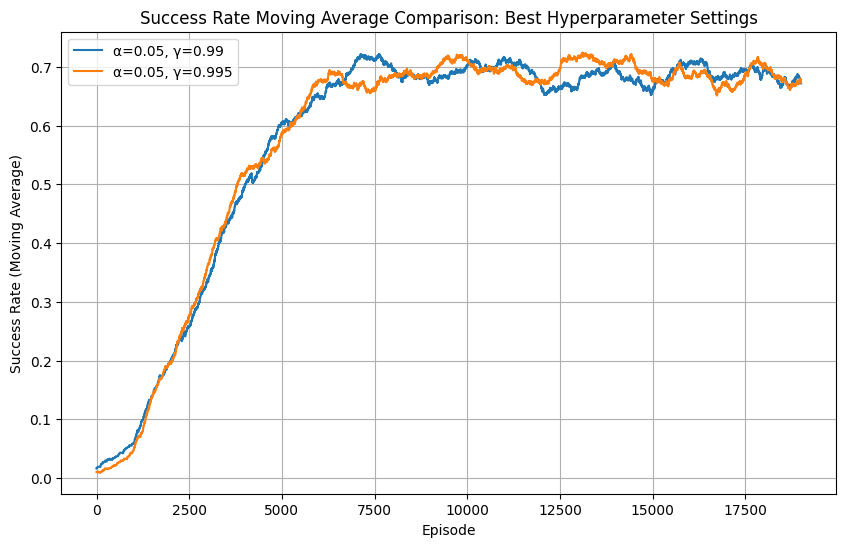

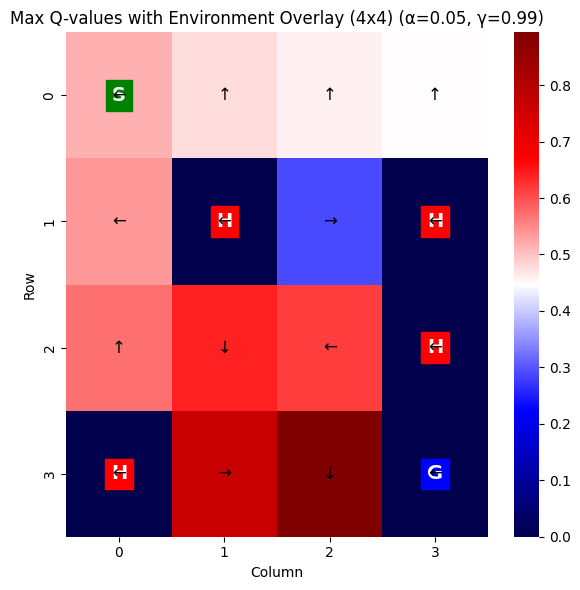

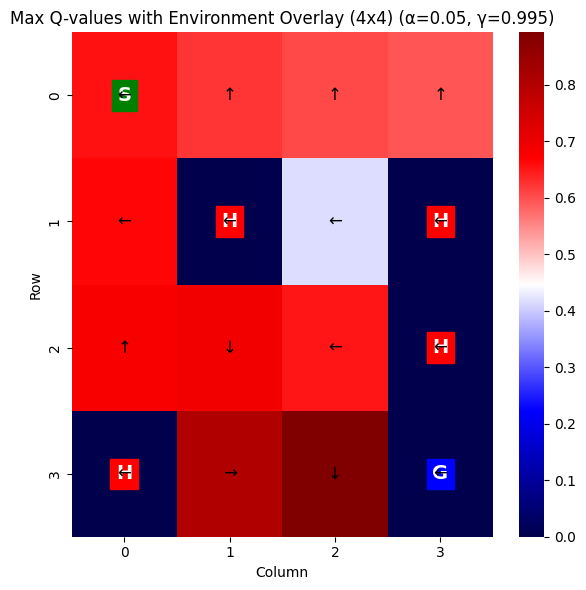

+------------------------------------+----------------+-----------------+
| Policy                             |   Success Rate |   Average Steps |
+====================================+================+=================+
| α=0.05, γ=0.99 (Post-Convergence)  |         0.6884 |           42.85 |
+------------------------------------+----------------+-----------------+
| α=0.05, γ=0.995 (Post-Convergence) |         0.6887 |           42.84 |
+------------------------------------+----------------+-----------------+


In [58]:
# visualize result of the best hyperparameter setting (alpha=0.05, gamma=0.99) and (alpha=0.05, gamma=0.995)
success_rate_moving_average(
    success_flags_list=[tuning_results[(0.05, 0.99)]['success_flags'], tuning_results[(0.05, 0.995)]['success_flags']],
    title="Success Rate Moving Average Comparison: Best Hyperparameter Settings",
    labels=["α=0.05, γ=0.99", "α=0.05, γ=0.995"],
    window_size=1000
)
best_Q_1 = tuning_results[(0.05, 0.99)]['Q']
best_Q_2 = tuning_results[(0.05, 0.995)]['Q']
plot_q_value_heatmap_with_env(
    best_Q_1,
    env_desc=env.unwrapped.desc,
    show_policy=True,
    cmap="seismic",
    title_suffix="(α=0.05, γ=0.99)"
)
plot_q_value_heatmap_with_env(
    best_Q_2,
    env_desc=env.unwrapped.desc,
    show_policy=True,
    cmap="seismic",
    title_suffix="(α=0.05, γ=0.995)"
)

table_success_rates(
    success_flags_list=[tuning_results[(0.05, 0.99)]['success_flags'][7000:], tuning_results[(0.05, 0.995)]['success_flags'][7000:]],
    total_steps_list=[tuning_results[(0.05, 0.99)]['total_steps'][7000:], tuning_results[(0.05, 0.995)]['total_steps'][7000:]],
    labels=["α=0.05, γ=0.99 (Post-Convergence)", "α=0.05, γ=0.995 (Post-Convergence)"]
)


In [52]:
# do the same for 8x8 map
tuning_results_8 = alpha_and_gamma_testing(alpha_values, gamma_values, map='8x8')

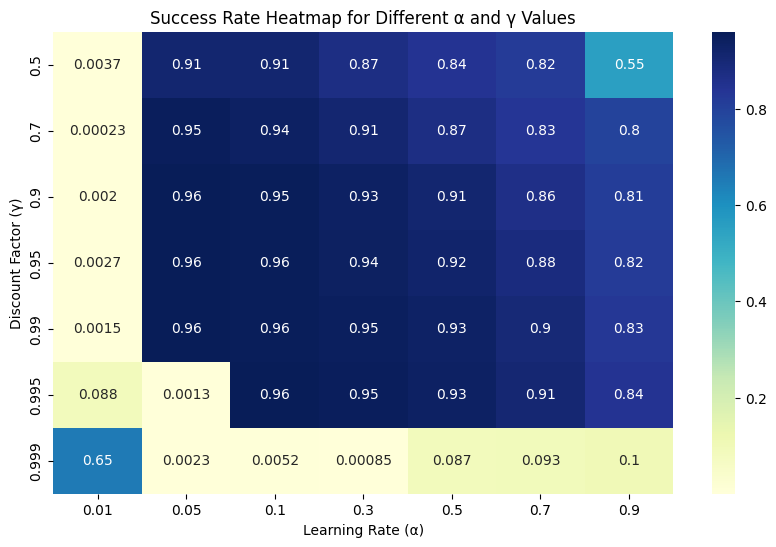

In [53]:
success_rate_heatmap(tuning_results_8, alpha_values, gamma_values)

here (alpha=0.1, gamma=0.95),(alpha=0.1, gamma=0.99),(alpha=0.1, gamma=0.995),(alpha=0.05, gamma=0.99),(alpha=0.05, gamma=0.95)
success_rate_moving_average looks like the safest 

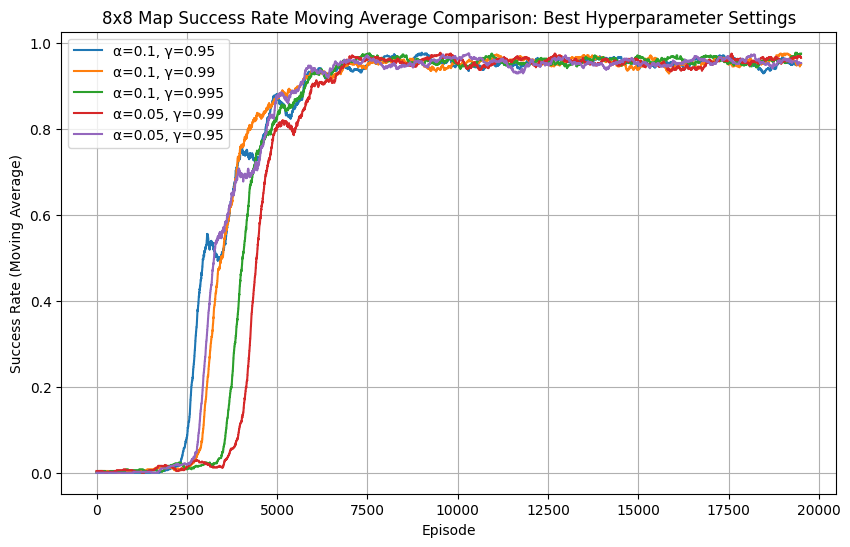

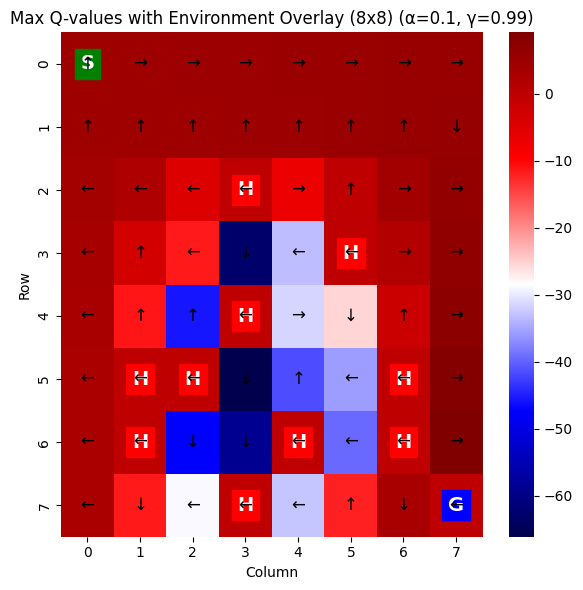

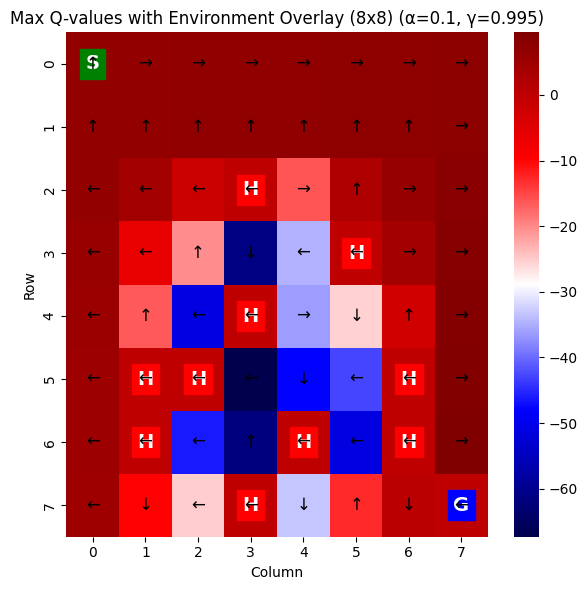

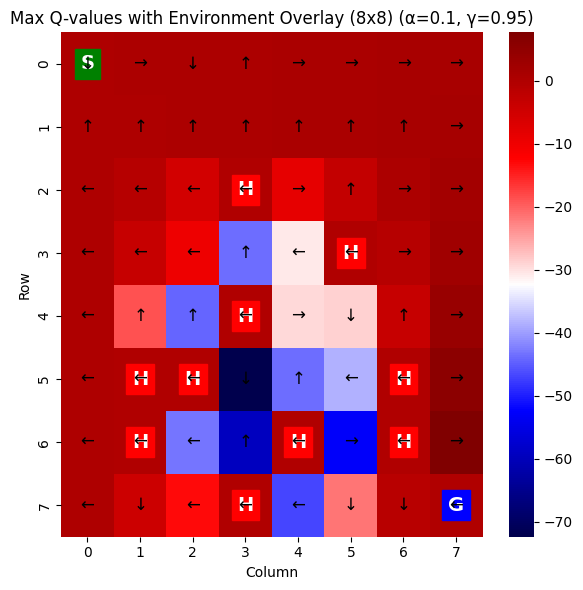

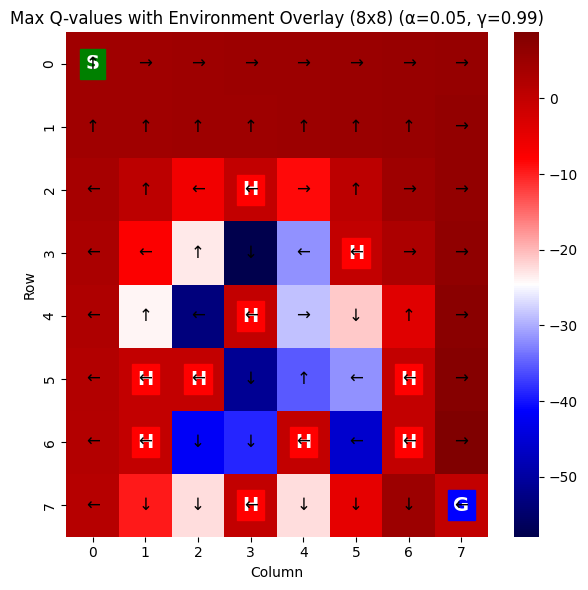

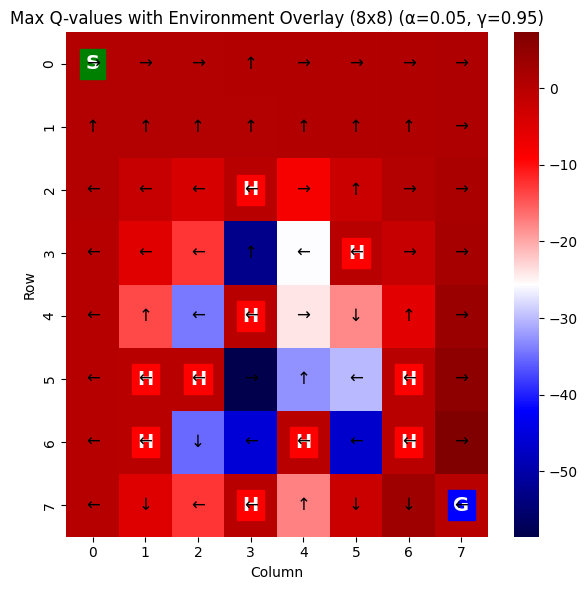

+-----------------------------------+----------------+-----------------+
| Policy                            |   Success Rate |   Average Steps |
+===================================+================+=================+
| α=0.1, γ=0.95 (Post-Convergence)  |         0.9555 |          125.16 |
+-----------------------------------+----------------+-----------------+
| α=0.1, γ=0.99 (Post-Convergence)  |         0.9558 |          123.49 |
+-----------------------------------+----------------+-----------------+
| α=0.1, γ=0.995 (Post-Convergence) |         0.9597 |          122.59 |
+-----------------------------------+----------------+-----------------+
| α=0.05, γ=0.99 (Post-Convergence) |         0.9577 |          118.9  |
+-----------------------------------+----------------+-----------------+
| α=0.05, γ=0.95 (Post-Convergence) |         0.9562 |          119.89 |
+-----------------------------------+----------------+-----------------+


In [64]:
# visualize the best hyperparameter setting (alpha=0.1, gamma=0.95),(alpha=0.1, gamma=0.99),(alpha=0.1, gamma=0.995),(alpha=0.05, gamma=0.99),(alpha=0.05, gamma=0.95)
success_rate_moving_average(
    success_flags_list=[
        tuning_results_8[(0.1, 0.95)]['success_flags'], tuning_results_8[(0.1, 0.99)]['success_flags'], tuning_results_8[(0.1, 0.995)]['success_flags'], tuning_results_8[(0.05, 0.99)]['success_flags'], tuning_results_8[(0.05, 0.95)]['success_flags']
    ],
    title="8x8 Map Success Rate Moving Average Comparison: Best Hyperparameter Settings",
    labels=["α=0.1, γ=0.95", "α=0.1, γ=0.99", "α=0.1, γ=0.995", "α=0.05, γ=0.99", "α=0.05, γ=0.95"],
    window_size=500
)
best_Q_8x8_1 = tuning_results_8[(0.1, 0.99)]['Q']
best_Q_8x8_2 = tuning_results_8[(0.1, 0.995)]['Q']
best_Q_8x8_3 = tuning_results_8[(0.1, 0.95)]['Q']
best_Q_8x8_4 = tuning_results_8[(0.05, 0.99)]['Q']
best_Q_8x8_5 = tuning_results_8[(0.05, 0.95)]['Q']

for i, (Q_best, title_suffix) in enumerate(zip(
    [best_Q_8x8_1, best_Q_8x8_2, best_Q_8x8_3, best_Q_8x8_4, best_Q_8x8_5],
    ["(α=0.1, γ=0.99)", "(α=0.1, γ=0.995)", "(α=0.1, γ=0.95)", "(α=0.05, γ=0.99)", "(α=0.05, γ=0.95)"]
)):
    plot_q_value_heatmap_with_env(
        Q_best,
        env_desc=env_8x8.unwrapped.desc,
        show_policy=True,
        cmap="seismic",
        title_suffix=title_suffix
    )
table_success_rates(
    success_flags_list=[tuning_results_8[(0.1, 0.95)]['success_flags'][7000:], tuning_results_8[(0.1, 0.99)]['success_flags'][7000:], tuning_results_8[(0.1, 0.995)]['success_flags'][7000:], tuning_results_8[(0.05, 0.99)]['success_flags'][7000:], tuning_results_8[(0.05, 0.95)]['success_flags'][7000:]],
    total_steps_list=[tuning_results_8[(0.1, 0.95)]['total_steps'][7000:], tuning_results_8[(0.1, 0.99)]['total_steps'][7000:], tuning_results_8[(0.1, 0.995)]['total_steps'][7000:], tuning_results_8[(0.05, 0.99)]['total_steps'][7000:], tuning_results_8[(0.05, 0.95)]['total_steps'][7000:]],
    labels=["α=0.1, γ=0.95 (Post-Convergence)", "α=0.1, γ=0.99 (Post-Convergence)", "α=0.1, γ=0.995 (Post-Convergence)", "α=0.05, γ=0.99 (Post-Convergence)", "α=0.05, γ=0.95 (Post-Convergence)"]
)


## Test with Algorithmic varients SARSA and Double Q-learning

### SARSA(State-Action-Reward-State-Action)

Q-learning updates using the best possible action in the next state, that is off-policy learning since it learns as if it always acted optimally, even if it didn't:
$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$
SARSA instead updates based on the action taken in the next step:
$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \ Q(s', a') - Q(s, a) \right]
$$
       
 

In [69]:
# function for SARSA
def SARSA_training(
    env: gym.Env,
    num_episodes: int = 20000,
    alpha: float = 0.1,
    gamma: float = 0.9,
    epsilon: float = 1.0,
    epsilon_min: float = 0.01,
    epsilon_decay_stepsize: int = 1000,
    step_penalty: float = 0.01,
    goal_reward_bonus: float = 10.0,
    hole_penalty: float = -100.0):
    '''SARSA algorithm implementation with reward shaping'''
    # Initialize Q-table
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))

    # Parameters for tracking progress
    rewards = []
    success_flags = []
    total_steps = []
    epsilon_initial = epsilon

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        steps = 0

        # choose the first action using e-greedy policy'
        action = epsilon_greedy_policy(Q, state, epsilon)

        while not done:
            next_state, real_reward, done, truncated, info = env.step(action)

            # reward shaping
            reward = real_reward
            if not done:
                reward += step_penalty
            if done and real_reward > 0:
                reward = goal_reward_bonus
            elif done and real_reward == 0:
                reward = hole_penalty
            
            # choose the next action for on-policy update
            if not done:
                next_action = epsilon_greedy_policy(Q, next_state, epsilon)
            else:
                next_action = None
            
            # ------SARSA Q-update----
            target = reward
            if not done:
                target += gamma*Q[next_state, next_action]
            Q[state, action] += alpha*(target-Q[state, action])
            # --------------------------------------

            state = next_state
            action = next_action if next_action is not None else action
            total_reward += reward
            steps += 1
            done = done or truncated
        
        #epsilon decay
        epsilon = epsilon_step_decay(
            episode,
            step_size = epsilon_decay_stepsize,
            epsilon_initial = epsilon_initial,
            epsilon_min = epsilon_min,
            decay_factor = 0.5
        )

        # record episode results
        rewards.append(total_reward)
        success_flags.append(1 if done and real_reward > 0 else 0)
        total_steps.append(steps)
    return Q, rewards, success_flags, total_steps, episode + 1



## Double Q-learning
This algorithm maintains two sperate Q-tables instead of one as in the standard Q-learning. At each step, one table is randomly chosen for updating, while the other is used to evaluate the chosen action. This mechanism is beleived to make this method more stable.
The update rules are:

$$
Q_1(s, a) \leftarrow Q_1(s, a) + \alpha \left[ r + \gamma \, Q_2\big(s', \arg\max_{a'} Q_1(s', a')\big) - Q_1(s, a) \right]
$$

and symmetrically:

$$
Q_2(s, a) \leftarrow Q_2(s, a) + \alpha \left[ r + \gamma \, Q_1\big(s', \arg\max_{a'} Q_2(s', a')\big) - Q_2(s, a) \right]
$$

By alternating updates between \( Q_1 \) and \( Q_2 \), Double Q-learning achieves more accurate value estimation and better performance in stochastic environments compared to standard Q-learning.


In [71]:
# double Q-learning implementation
def double_q_learning_training(
        env: gym.Env,
        num_episodes: int = 20000,
        alpha: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 1.0,
        epsilon_min: float = 0.01,
        epsilon_decay_stepsize: int = 1000,
        step_penalty: float = 0.01,
        goal_reward_bonus: float = 10.0,
        hole_penalty: float = -100.0
    ):
    '''Double Q-learning algorithm implementation with reward shaping'''
    # Initialize two Q-tables
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q1 = np.zeros((n_states, n_actions))
    Q2 = np.zeros((n_states, n_actions))
    epsilon_initial = epsilon

    # Parameters for tracking progress
    rewards = []
    success_flags = []
    total_steps = []

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        steps = 0
        while not done:
            action = epsilon_greedy_policy(Q1 + Q2, state, epsilon)

            next_state, real_reward, done, truncated, info = env.step(action)

            # reward shaping
            reward = real_reward
            if not done:
                reward += step_penalty
            if done and real_reward > 0:
                reward = goal_reward_bonus
            elif done and real_reward == 0:
                reward = hole_penalty

            # Randomly update one of the Q-tables
            if np.random.rand() < 0.5:
                # Update Q1
                best_next_action = np.argmax(Q1[next_state])
                target = reward + gamma * Q2[next_state, best_next_action] * (not done)
                Q1[state, action] += alpha * (target - Q1[state, action])
            else:
                # Update Q2
                best_next_action = np.argmax(Q2[next_state])
                target = reward + gamma * Q1[next_state, best_next_action] * (not done)
                Q2[state, action] += alpha * (target - Q2[state, action])

            state = next_state
            total_reward += reward
            steps += 1
            done = done or truncated
        # Decay epsilon
        epsilon = epsilon_step_decay(
            epsilon,
            epsilon_min,
            epsilon_decay_stepsize,
            episode
        )
        
        # record episode results
        rewards.append(total_reward)
        success_flags.append(1 if done and real_reward > 0 else 0)
        total_steps.append(steps)
        
    # Combine the two Q-tables
    Q = Q1 + Q2
    return Q, rewards, success_flags, total_steps, episode + 1

In [74]:
# run SARSA and Double Q-learning on 4x4 map and compare with the best Q-learning result
Q_Sar, rewards_sar, success_sar, steps_sar, episodes_sar = SARSA_training(
    env,
    num_episodes=20000,
    alpha=0.05,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay_stepsize=1000,
    step_penalty=0.0,
    goal_reward_bonus=1.0,
    hole_penalty= 0.0
)

Q_Double, rewards_double, success_double, steps_double, episodes_double = double_q_learning_training(
    env,
    num_episodes=20000,
    alpha=0.05,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay_stepsize=1000,
    step_penalty=0.0,
    goal_reward_bonus=1.0,
    hole_penalty= 0.0
)


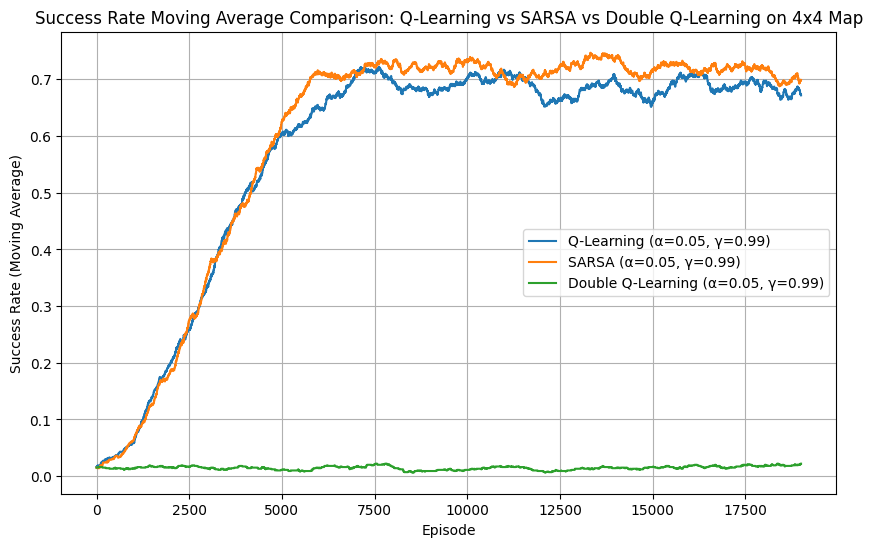

+-------------------------------------------------------+----------------+-----------------+
| Policy                                                |   Success Rate |   Average Steps |
+=======================================================+================+=================+
| Q-Learning (α=0.05, γ=0.99) (Post-Convergence)        |         0.6884 |           42.85 |
+-------------------------------------------------------+----------------+-----------------+
| SARSA (α=0.05, γ=0.99) (Post-Convergence)             |         0.7184 |           41.35 |
+-------------------------------------------------------+----------------+-----------------+
| Double Q-Learning (α=0.05, γ=0.99) (Post-Convergence) |         0.0148 |            7.7  |
+-------------------------------------------------------+----------------+-----------------+


In [75]:
# compare success rates
success_rate_moving_average([tuning_results[(0.05, 0.99)]['success_flags'], success_sar, success_double],
    title="Success Rate Moving Average Comparison: Q-Learning vs SARSA vs Double Q-Learning on 4x4 Map",
    labels=["Q-Learning (α=0.05, γ=0.99)", "SARSA (α=0.05, γ=0.99)", "Double Q-Learning (α=0.05, γ=0.99)"],
    window_size=1000
)
table_success_rates(
    success_flags_list=[tuning_results[(0.05, 0.99)]['success_flags'][7000:], success_sar[7000:], success_double[7000:]],
    total_steps_list=[tuning_results[(0.05, 0.99)]['total_steps'][7000:], steps_sar[7000:], steps_double[7000:]],
    labels=["Q-Learning (α=0.05, γ=0.99) (Post-Convergence)", "SARSA (α=0.05, γ=0.99) (Post-Convergence)", "Double Q-Learning (α=0.05, γ=0.99) (Post-Convergence)"]
)


In [76]:
# do the same for 8x8 map
Q_Sar_8x8, rewards_sar_8x8, success_sar_8x8, steps_sar_8x8, episodes_sar_8x8 = SARSA_training(
    env_8x8,
    num_episodes=20000,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay_stepsize=1000,
    step_penalty=0.01,
    goal_reward_bonus=10.0,
    hole_penalty= -100.0
)
Q_Double_8x8, rewards_double_8x8, success_double_8x8, steps_double_8x8, episodes_double_8x8 = double_q_learning_training(
    env_8x8,
    num_episodes=20000,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay_stepsize=1000,
    step_penalty=0.01,
    goal_reward_bonus=10.0,
    hole_penalty= -100.0
)

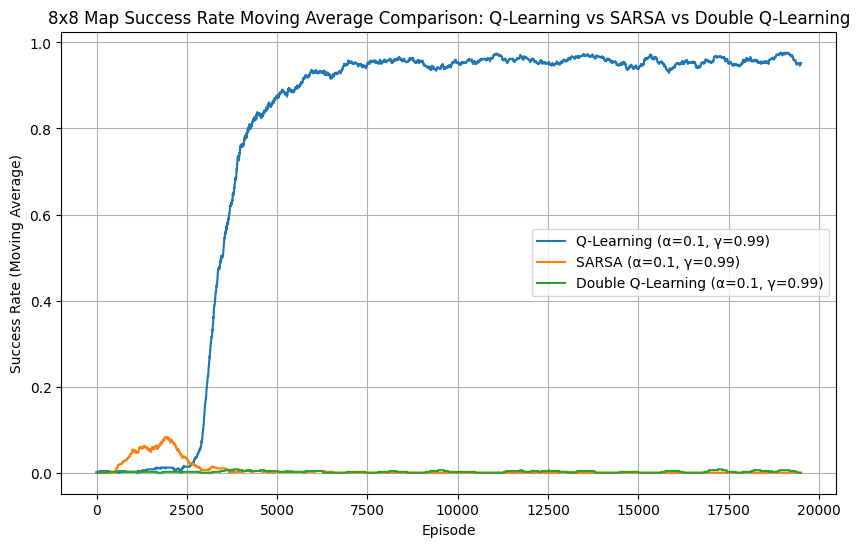

+------------------------------------------------------+----------------+-----------------+
| Policy                                               |   Success Rate |   Average Steps |
+======================================================+================+=================+
| Q-Learning (α=0.1, γ=0.99) (Post-Convergence)        |         0.9558 |          123.49 |
+------------------------------------------------------+----------------+-----------------+
| SARSA (α=0.1, γ=0.99) (Post-Convergence)             |         0.0001 |          498.52 |
+------------------------------------------------------+----------------+-----------------+
| Double Q-Learning (α=0.1, γ=0.99) (Post-Convergence) |         0.0022 |           32.05 |
+------------------------------------------------------+----------------+-----------------+


In [77]:
# compare the results with best Q-learning result on 8x8 map
success_rate_moving_average([tuning_results_8[(0.1, 0.99)]['success_flags'], success_sar_8x8, success_double_8x8],
    title="8x8 Map Success Rate Moving Average Comparison: Q-Learning vs SARSA vs Double Q-Learning",
    labels=["Q-Learning (α=0.1, γ=0.99)", "SARSA (α=0.1, γ=0.99)", "Double Q-Learning (α=0.1, γ=0.99)"],
    window_size=500
)
table_success_rates(
    success_flags_list=[tuning_results_8[(0.1, 0.99)]['success_flags'][7000:], success_sar_8x8[7000:], success_double_8x8[7000:]],
    total_steps_list=[tuning_results_8[(0.1, 0.99)]['total_steps'][7000:], steps_sar_8x8[7000:], steps_double_8x8[7000:]],
    labels=["Q-Learning (α=0.1, γ=0.99) (Post-Convergence)", "SARSA (α=0.1, γ=0.99) (Post-Convergence)", "Double Q-Learning (α=0.1, γ=0.99) (Post-Convergence)"]
)